In [ ]:
!pip install tensorflow tensorflow_datasets

In [ ]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255


11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
print(len(train_images[50000:]))
print(len(train_labels[50000:]))

10000
10000


In [ ]:
valid_images = train_images[50000:]
valid_labels = train_labels[50000:]

train_images = train_images[:50000]
train_labels = train_labels[:50000]

test_images = test_images
test_labels = test_labels

print(len(train_images))
print(len(valid_images))
print(len(test_images))

50000
10000
10000


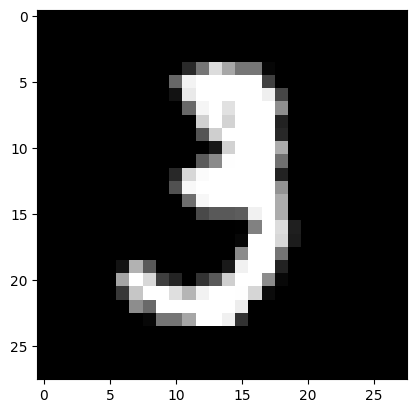

In [ ]:
import matplotlib.pyplot as plt

def preview_dataset(image):
    # plot the sample
    fig = plt.figure
    plt.imshow(image, cmap='gray')
    plt.show()

preview_dataset(train_images[10])

In [ ]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

print(train_dataset)
print(valid_dataset)
print(test_dataset)

<_TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>
<_TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>
<_TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>


In [ ]:
train_ds = train_dataset.shuffle(1000).batch(128).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_dataset.shuffle(1000).batch(128).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_dataset.shuffle(1000).batch(128).prefetch(tf.data.experimental.AUTOTUNE)

print(train_ds)
print(valid_ds)
print(test_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>


## lr = 1e-4

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(28, 28, 1))
#x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(inputs)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'xception_50epch',
        save_best_only=True,
        monitor='val_loss'
    )
]
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds,
    callbacks=callbacks)

Epoch 1/50
391/391 [==============================] - 33s 37ms/step - loss: 0.7867 - accuracy: 0.7871 - val_loss: 2.8320 - val_accuracy: 0.1064
Epoch 2/50
391/391 [==============================] - 12s 31ms/step - loss: 0.1082 - accuracy: 0.9682 - val_loss: 0.0933 - val_accuracy: 0.9733
Epoch 3/50
391/391 [==============================] - 18s 45ms/step - loss: 0.0644 - accuracy: 0.9812 - val_loss: 0.0576 - val_accuracy: 0.9827
Epoch 4/50
391/391 [==============================] - 12s 31ms/step - loss: 0.0466 - accuracy: 0.9861 - val_loss: 0.0508 - val_accuracy: 0.9851
Epoch 5/50
391/391 [==============================] - 8s 20ms/step - loss: 0.0329 - accuracy: 0.9904 - val_loss: 0.0517 - val_accuracy: 0.9842
Epoch 6/50
391/391 [==============================] - 13s 33ms/step - loss: 0.0247 - accuracy: 0.9931 - val_loss: 0.0430 - val_accuracy: 0.9866
Epoch 7/50
391/391 [==============================] - 13s 33ms/step - loss: 0.0179 - accuracy: 0.9949 - val_loss: 0.0426 - val_accuracy: 

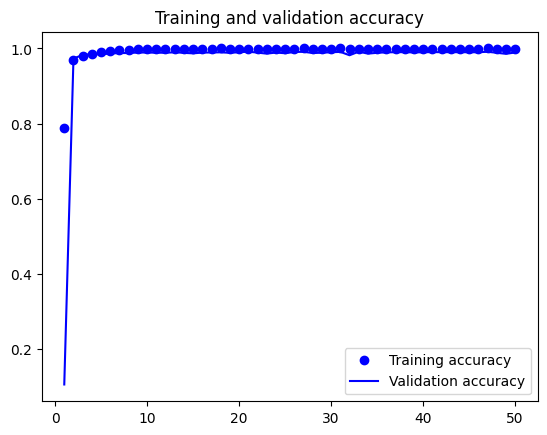

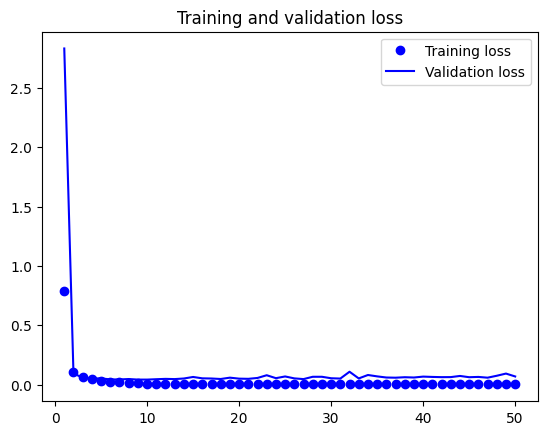

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

79/79 [==============================] - 1s 6ms/step - loss: 0.0344 - accuracy: 0.9900
Evaluation Time: 0.7827112674713135 seconds
Test Accuracy: 0.9900000095367432
Test Loss: 0.034382667392492294


(0.0, 1.9900000095367432)

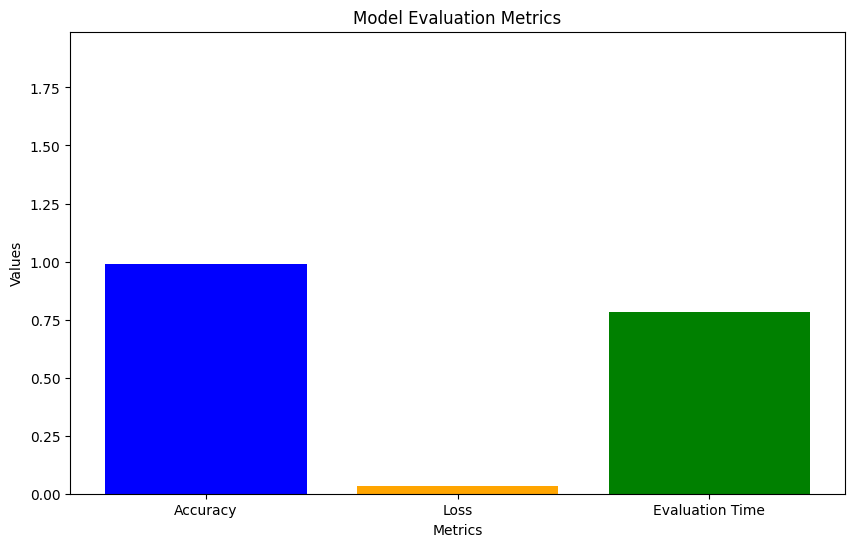

In [ ]:
import time
import matplotlib.pyplot as plt
from tensorflow import keras

test_model = keras.models.load_model('xception_50epch')
start_time = time.time()
test_loss, test_acc = test_model.evaluate(test_ds)
end_time = time.time()
eval_time = end_time - start_time

print(f"Evaluation Time: {eval_time} seconds")
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

#그래프 그리기
metrics = ['Accuracy', 'Loss', 'Evaluation Time']
values = [test_acc, test_loss, eval_time]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'orange', 'green'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Evaluation Metrics')
plt.ylim(0, max(values) + 1)  # Adjust


## lr = 1e-5

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(28, 28, 1))
#x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(inputs)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'xception_50epch',
        save_best_only=True,
        monitor='val_loss'
    )
]
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds,
    callbacks=callbacks)

Epoch 1/50
391/391 [==============================] - 20s 35ms/step - loss: 2.1360 - accuracy: 0.3420 - val_loss: 2.2900 - val_accuracy: 0.1107
Epoch 2/50
391/391 [==============================] - 12s 31ms/step - loss: 1.6044 - accuracy: 0.6092 - val_loss: 1.2797 - val_accuracy: 0.7719
Epoch 3/50
391/391 [==============================] - 13s 32ms/step - loss: 1.0114 - accuracy: 0.7776 - val_loss: 0.6967 - val_accuracy: 0.8806
Epoch 4/50
391/391 [==============================] - 13s 32ms/step - loss: 0.6175 - accuracy: 0.8676 - val_loss: 0.4195 - val_accuracy: 0.9201
Epoch 5/50
391/391 [==============================] - 12s 32ms/step - loss: 0.4036 - accuracy: 0.9081 - val_loss: 0.2836 - val_accuracy: 0.9390
Epoch 6/50
391/391 [==============================] - 13s 33ms/step - loss: 0.2925 - accuracy: 0.9284 - val_loss: 0.2137 - val_accuracy: 0.9502
Epoch 7/50
391/391 [==============================] - 13s 33ms/step - loss: 0.2304 - accuracy: 0.9413 - val_loss: 0.1740 - val_accuracy:

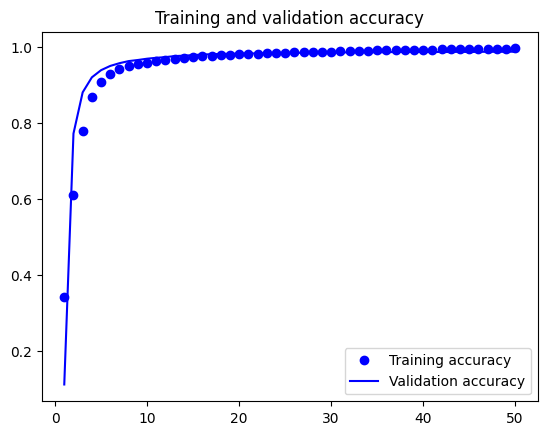

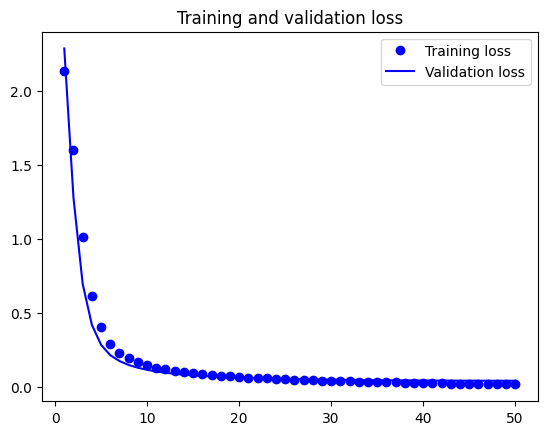

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

79/79 [==============================] - 1s 6ms/step - loss: 0.0353 - accuracy: 0.9880
Evaluation Time: 0.8277754783630371 seconds
Test Accuracy: 0.9879999756813049
Test Loss: 0.03530925139784813


(0.0, 1.987999975681305)

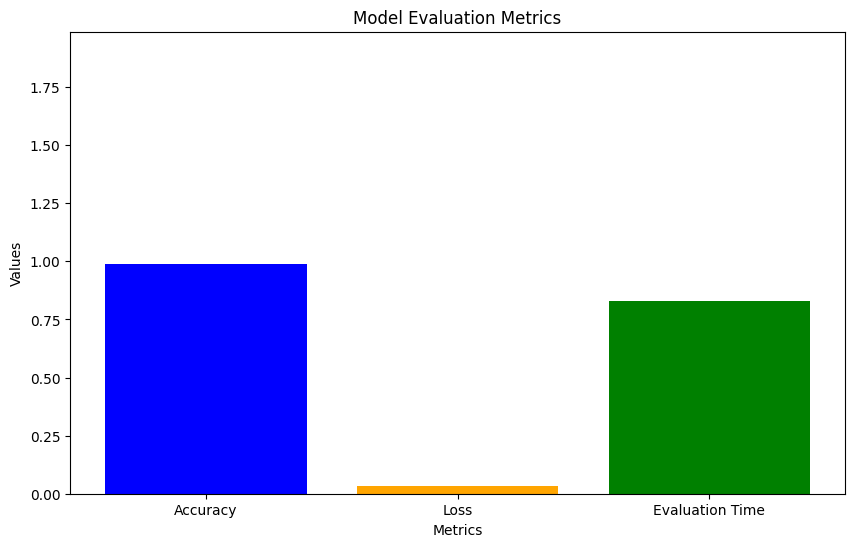

In [ ]:
import time
import matplotlib.pyplot as plt
from tensorflow import keras

test_model = keras.models.load_model('xception_50epch')
start_time = time.time()
test_loss, test_acc = test_model.evaluate(test_ds)
end_time = time.time()
eval_time = end_time - start_time

print(f"Evaluation Time: {eval_time} seconds")
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

#그래프 그리기
metrics = ['Accuracy', 'Loss', 'Evaluation Time']
values = [test_acc, test_loss, eval_time]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'orange', 'green'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Evaluation Metrics')
plt.ylim(0, max(values) + 1)  # Adjust
